In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
from math import e
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from data.load import get_patched_data, get_patched_src, subsample
from data.utils import custom_cutout

## Choose Devices

In [5]:
gpu_id = 1
num_cores = 4

In [6]:
torch.cuda.set_device(gpu_id)

## Set Experiment Name

In [7]:
nb_name = 'clr_expt_2'

## Load Data

In [8]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_pth = data_pth/f'EM/models/self_sv/contrastive'  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

/home/alaa/Dropbox/BPHO Staff/USF
/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/contrastive


In [9]:
def get_clr_data(data_pth, hr_dir, bs, in_sz, out_sz,
                 xtra_tfms=None, num_workers=4, noise=None, 
                 max_zoom=1.1):
    src = get_clr_src(data_pth, hr_dir)
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom,
                          xtra_tfms=xtra_tfms)
    data = (src
                .transform(tfms, size=in_sz, 
                           resize_method=ResizeMethod.CROP, tfm_y=False)
                .transform_y(None, size=out_sz, 
                             resize_method=ResizeMethod.CROP)
                .databunch(bs=bs, num_workers=num_workers)
                .normalize(imagenet_stats, do_y=True))
    data.c = 3
    data.train_ds.tfms_y = None
    data.valid_ds.tfms_y = None
    return data


def get_clr_src(data_pth, hr_dir):
    hr_tifs = data_pth/f'{hr_dir}'

    def map_to_hr(x):
        return hr_tifs/x.relative_to(hr_tifs).with_suffix(".tif")

    src = (ImageImageList
            .from_folder(hr_tifs)
            .split_by_rand_pct()
            .label_from_func(map_to_hr))
    return src

In [10]:
random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                       min_length=5, max_length=10, use_on_y=False)

In [11]:
patch_tfms = [random_patch()]

In [12]:
# Create databunch
size = 128
bs = 64
data = get_clr_data(data_pth, hr_dir, bs, xtra_tfms=patch_tfms,
                    in_sz=size, out_sz=size)

In [13]:
# Dataset sizes
len(data.train_ds), len(data.valid_ds)

(79998, 19999)

In [14]:
# Batch size and number of batches
data.batch_size, len(data.train_dl)

(64, 1249)

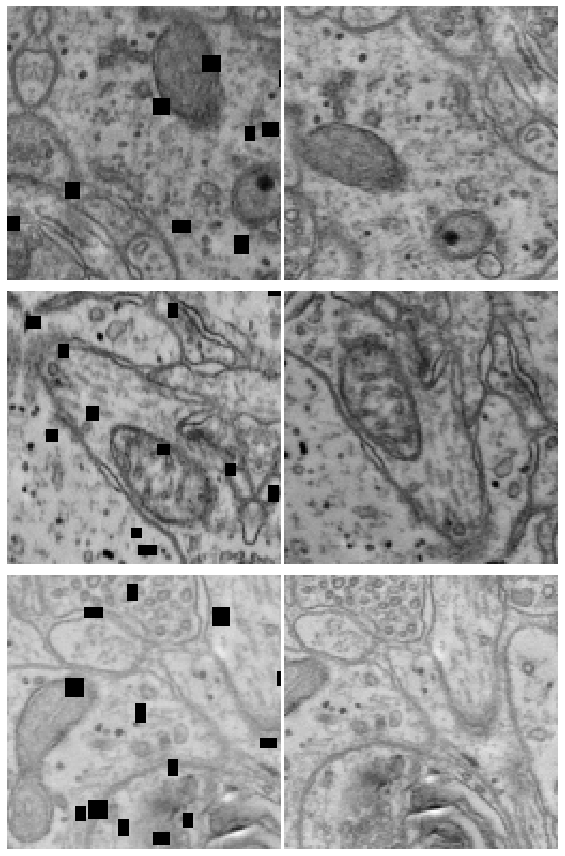

In [15]:
# Data Visualization
data.show_batch(rows=3)

## Data Subsample

In [16]:
# data = subsample(data)

In [17]:
data.c

3

In [18]:
# Dataset sizes
len(data.train_dl), len(data.valid_dl)

(1249, 313)

In [19]:
# Batch size and number of batches
data.batch_size

64

# Model

In [20]:
class SimCLR(nn.Module):
    """
    We opt for simplicity and adopt the commonly used ResNet (He et al., 2016) 
    to obtain hi = f(x ̃i) = ResNet(x ̃i) where hi ∈ Rd is the 
    output after the average pooling layer.
    """

    def __init__(self, arch="resnet50", projection_dim=128, 
                 normalize=True):
        super(SimCLR, self).__init__()

        self.encoder = self.get_arch(arch)
        self.normalize = normalize

        self.n_features = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False),
        )
        

    def get_arch(self, name):
        resnets = {
            "resnet18": models.resnet18(),
            "resnet34": models.resnet34(),
            "resnet50": models.resnet50()
        }
        if name not in resnets.keys():
            raise KeyError(f"{name} is not a valid architecture")
        return resnets[name]


    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)

        if self.normalize:
            z = nn.functional.normalize(z, dim=1)
        return z

In [21]:
class ContrastiveCallback(LearnerCallback):
    def __init__(self, learn:Learner):
        super().__init__(learn)
    
    def on_batch_begin(self, last_input, last_target, **kwargs):
        xb_1 = last_input # (bs x w x h)
        xb_2 = last_target
        xb = (torch.cat([xb_1, xb_2], dim=0),) # (bs*2 x w x h)
        return {'last_input': xb, 'last_target': torch.tensor([1.])}

# Loss

In [22]:
class NT_Xent(nn.Module):
    def __init__(self, 
                 temperature=0.1, device=0):
        super(NT_Xent, self).__init__()
        self.temperature = temperature
        self.device = f'cuda:{device}'

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        mask = torch.ones((batch_size * 2, batch_size * 2), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_all, useless):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
#         pdb.set_trace()
        self.batch_size = z_all.shape[0] // 2
        self.mask = self.mask_correlated_samples(self.batch_size)
        sim = self.similarity_f(z_all.unsqueeze(1), z_all.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
#         pdb.set_trace()
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(
            self.batch_size * 2, 1
        )
        negative_samples = sim[self.mask].reshape(self.batch_size * 2, -1)

        labels = torch.zeros(self.batch_size * 2).to(self.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= 2 * self.batch_size
        return loss

In [23]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 3, 128, 128]))

In [24]:
m = SimCLR(arch='resnet34')
nce = NT_Xent(device=gpu_id)

In [25]:
wd = 1e-3
learn = Learner(data, m, loss_func=nce,
                wd=wd, model_dir=model_pth)

In [26]:
clr_cb = ContrastiveCallback(learn)
learn.callbacks.append(clr_cb)

## Initialization

In [27]:
learn.model_dir = model_pth
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/contrastive


## Load Model (optional)

In [28]:
# learn.model_dir = model_pth
learn = learn.load(f'{nb_name}.1a')

## Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


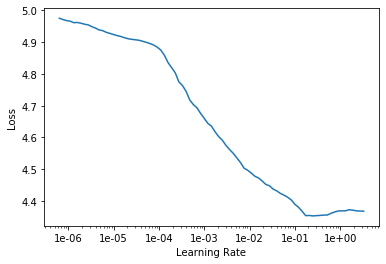

In [30]:
# %debug
learn.lr_find()
learn.recorder.plot()

### 1a

In [31]:
lr = 3e-3
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1a')

epoch,train_loss,valid_loss,time
0,1.116416,0.356500,17:20
1,0.461660,0.130263,16:54
2,0.296977,0.076275,16:33


In [56]:
learn.save(f'{nb_name}.1a')

### 1b

In [32]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


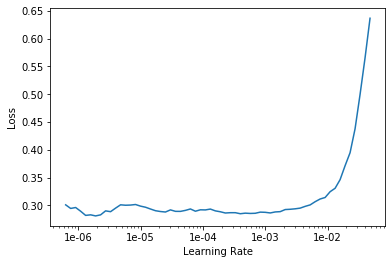

In [33]:
learn.lr_find()
learn.recorder.plot()

In [64]:
learn = learn.load(f'{nb_name}.1a')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


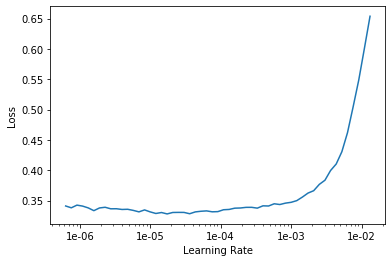

In [66]:
learn.lr_find()
learn.recorder.plot()

In [29]:
# %debug
lr = 1e-4
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1b')

epoch,train_loss,valid_loss,time
0,0.291792,0.071937,17:28
1,0.275934,0.069020,16:31
2,0.275874,0.067576,16:22


In [30]:
# Create databunch
size = 256
bs = 32
data = get_clr_data(data_pth, hr_dir, bs, xtra_tfms=patch_tfms,
                    in_sz=size, out_sz=size)

In [31]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


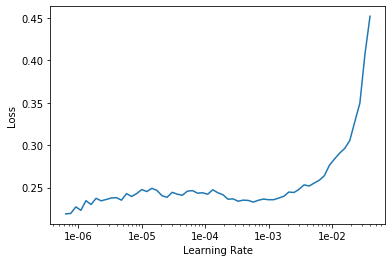

In [32]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.load(f'{nb_name}.1b')

In [33]:
# %debug
lr = 1e-4
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2a')

epoch,train_loss,valid_loss,time
0,0.109100,0.039707,34:12
1,0.091737,0.035759,34:27
2,0.089882,0.037382,34:16


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


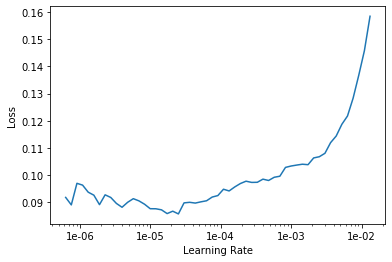

In [34]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [35]:
# %debug
lr = 1e-4
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2b')

epoch,train_loss,valid_loss,time
0,0.090524,0.037000,35:12
1,0.088299,0.036298,34:28
2,0.076094,0.033013,34:29


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
# Create databunch
size = 512
bs = 16
data = get_clr_data(data_pth, hr_dir, bs, xtra_tfms=patch_tfms,
                    in_sz=size, out_sz=size)

In [37]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


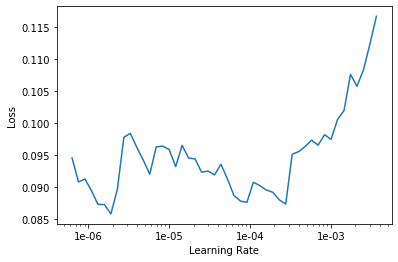

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
# %debug
lr = 1e-4
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3a')

epoch,train_loss,valid_loss,time
0,0.036531,0.020739,39:25
1,0.025870,0.018775,38:33
2,0.024817,0.018937,38:26


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Traceback (most recent call last):


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


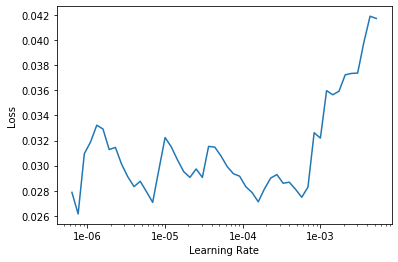

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
# %debug
lr = 1e-4
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3b')

epoch,train_loss,valid_loss,time
0,0.027671,0.022588,38:51
1,0.021930,0.020335,39:01
2,0.027149,0.017670,39:21


In [43]:
learn = learn.load(f'{nb_name}.3b')

In [42]:
# %debug
lr = 1e-5
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3c')

epoch,train_loss,valid_loss,time
0,0.021961,0.017753,39:23
1,0.025764,0.019081,38:43
2,0.020017,0.019278,38:50


In [45]:
aq v    

SyntaxError: invalid syntax (<ipython-input-45-4e34397da1e4>, line 1)

In [ ]:
ZA  c